## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-distilroberta-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-distilroberta-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-distilroberta-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-distilroberta-96/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-distilroberta-96/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-distilroberta-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_1/y_train.npy
fold_2/
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_2/y_train.npy
fold_3/
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_3/y_train.npy


# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 16,
  "EPOCHS": 7,
  "LEARNING_RATE": 5e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'distilroberta-base-tf_model.h5',
  "config_path": base_path + 'distilroberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [4]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
#     sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    last_state = sequence_output[0]
    
    x_start = layers.Conv1D(1, 1)(last_state)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Dense(MAX_LEN, activation='softmax', name='y_start')(x_start)   

    x_end = layers.Conv1D(1, 1)(last_state)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Dense(MAX_LEN, activation='softmax', name='y_end')(x_end) 
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=[metrics.CategoricalAccuracy()])
    
    return model

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

# Train

In [6]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    model = model_fn(config['MAX_LEN'])
    tb_callback = TensorBoard(log_dir='./')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)

    history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[checkpoint, es, tb_callback],
                    epochs=config['EPOCHS'], 
                    batch_size=config['BATCH_SIZE'],
                    verbose=2).history
    history_list.append(history)

    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'start_fold_%d' % (n_fold+1)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'end_fold_%d' % (n_fold+1)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'start_fold_%d' % (n_fold+1)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'end_fold_%d' % (n_fold+1)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold+1)] = k_fold['end_fold_%d' % (n_fold+1)].astype(int)
    k_fold['start_fold_%d' % (n_fold+1)] = k_fold['start_fold_%d' % (n_fold+1)].astype(int)
    k_fold['end_fold_%d' % (n_fold+1)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold+1)].clip(0, k_fold['end_fold_%d' % (n_fold+1)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold+1)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold+1)], x['end_fold_%d' % (n_fold+1)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold+1)].fillna('', inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold+1)] = k_fold.apply(lambda x: jaccard(x['text'], x['prediction_fold_%d' % (n_fold+1)]), axis=1)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/7

Epoch 00001: val_loss improved from inf to 3.15590, saving model to model_fold_1.h5
21984/21984 - 175s - loss: 4.7614 - y_start_loss: 1.9831 - y_end_loss: 2.7783 - y_start_categorical_accuracy: 0.5586 - y_end_categorical_accuracy: 0.2974 - val_loss: 3.1559 - val_y_start_loss: 1.5404 - val_y_end_loss: 1.6166 - val_y_start_categorical_accuracy: 0.5782 - val_y_end_categorical_accuracy: 0.5819
Epoch 2/7

Epoch 00002: val_loss improved from 3.15590 to 2.64072, saving model to model_fold_1.h5
21984/21984 - 164s - loss: 3.0035 - y_start_loss: 1.4386 - y_end_loss: 1.5650 - y_start_categorical_accuracy: 0.5974 - y_end_categorical_accuracy: 0.5714 - val_loss: 2.6407 - val_y_start_loss: 1.2877 - val_y_end_loss: 1.3523 - val_y_start_categorical_accuracy: 0.6137 - val_y_end_categorical_accuracy: 0.6356
Epoch 3/7

Epoch 00003: val_loss improved from 2.64072 to 2.48128, saving model to model_fold_1.h5
21984/21984 - 164s - loss: 2.52

In [7]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1587061750.de6f8bbb2246.12.212603.v2
train/events.out.tfevents.1587059968.de6f8bbb2246.12.5717.v2
train/events.out.tfevents.1587059979.de6f8bbb2246.profile-empty
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-16_18-14-30/
train/plugins/profile/2020-04-16_18-14-30/local.trace
train/plugins/profile/2020-04-16_18-29-17/
train/plugins/profile/2020-04-16_18-29-17/local.trace
train/plugins/profile/2020-04-16_17-59-39/
train/plugins/profile/2020-04-16_17-59-39/local.trace
train/events.out.tfevents.1587060863.de6f8bbb2246.12.109160.v2
validation/
validation/events.out.tfevents.1587060144.de6f8bbb2246.12.33549.v2
validation/events.out.tfevents.1587061034.de6f8bbb2246.12.136992.v2
validation/events.out.tfevents.1587061922.de6f8bbb2246.12.240435.v2


# Model loss graph

Fold: 1


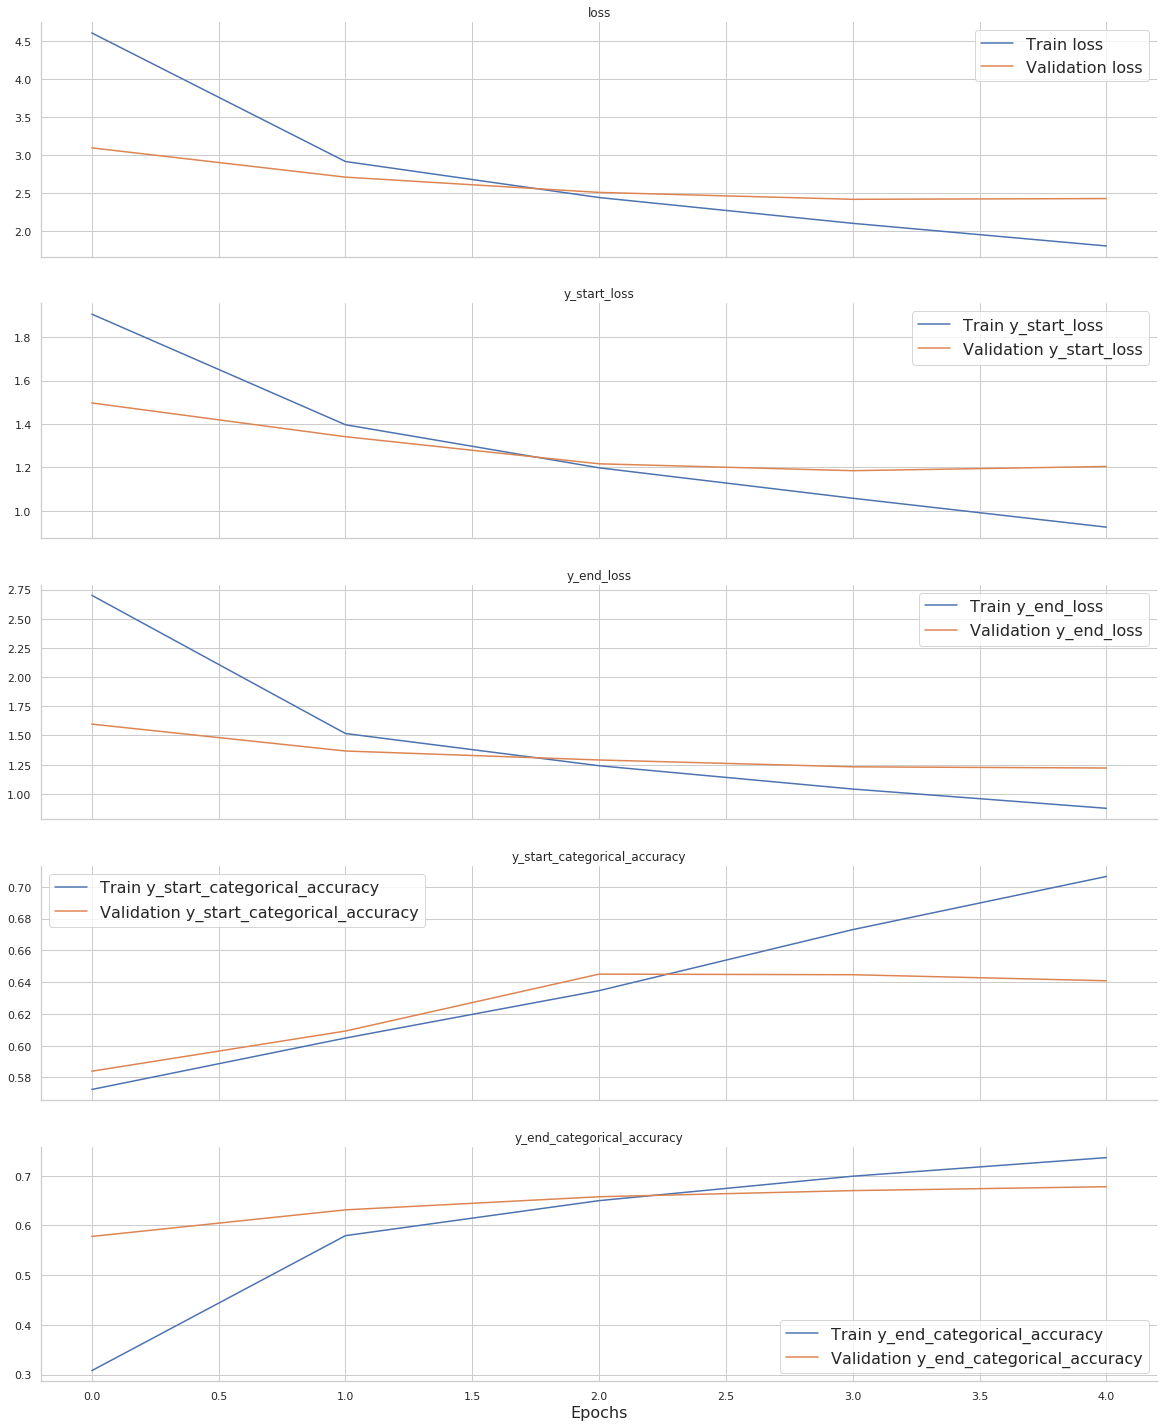

Fold: 2


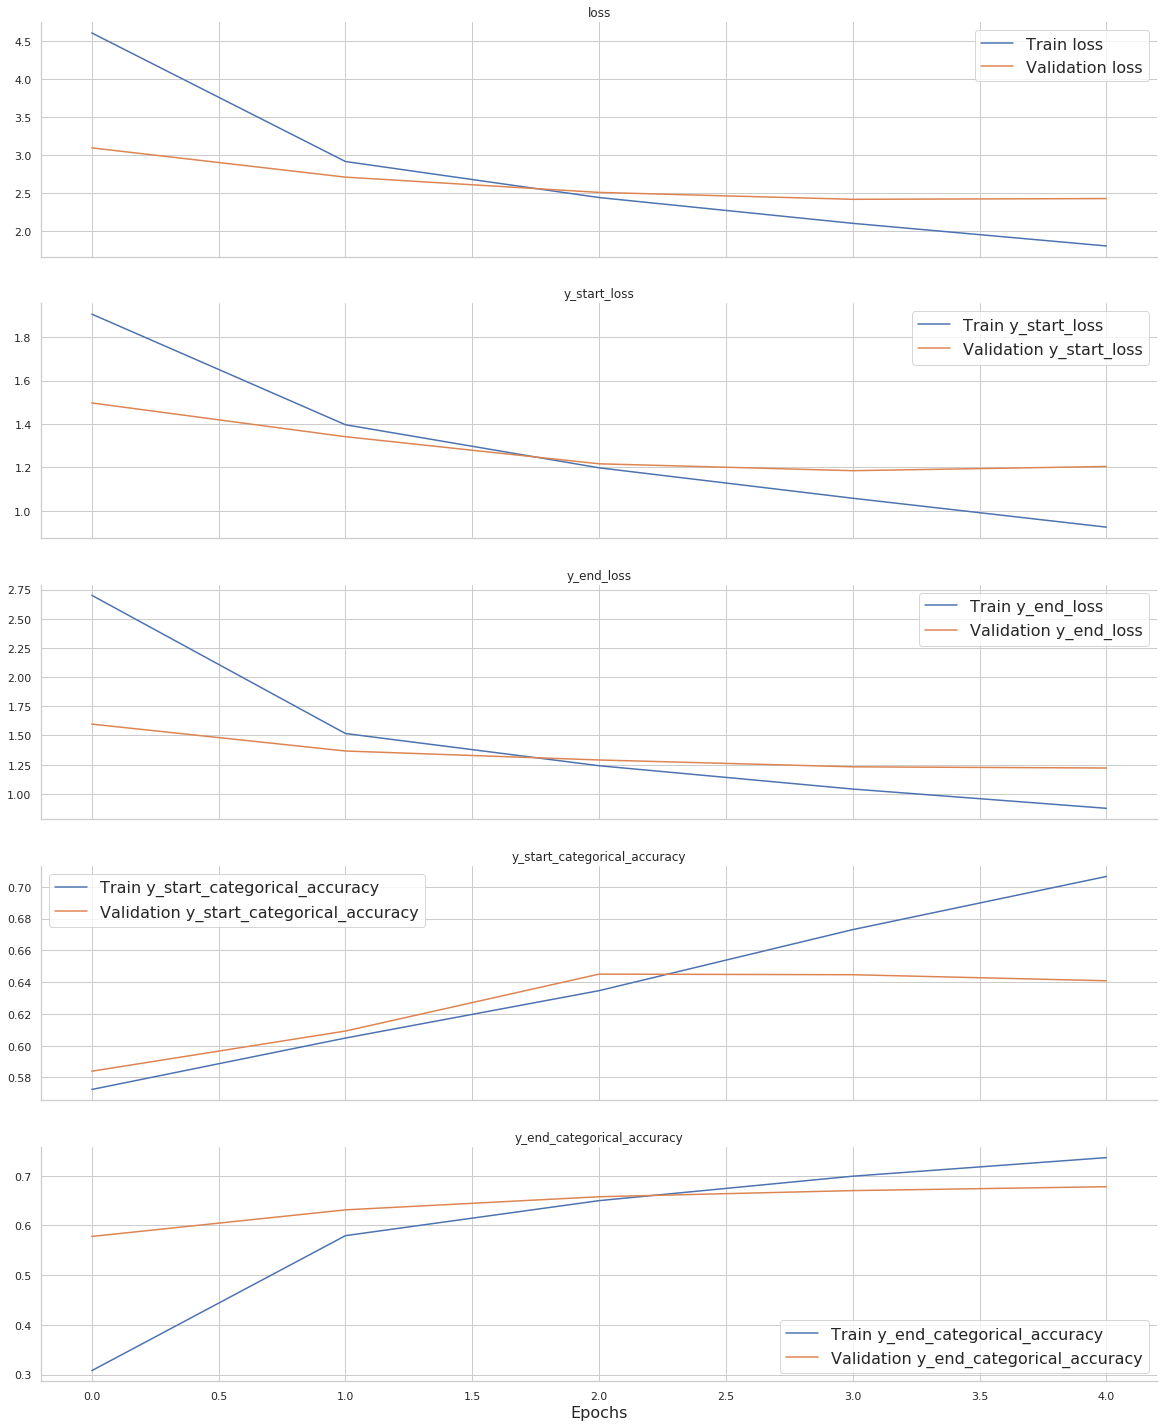

Fold: 3


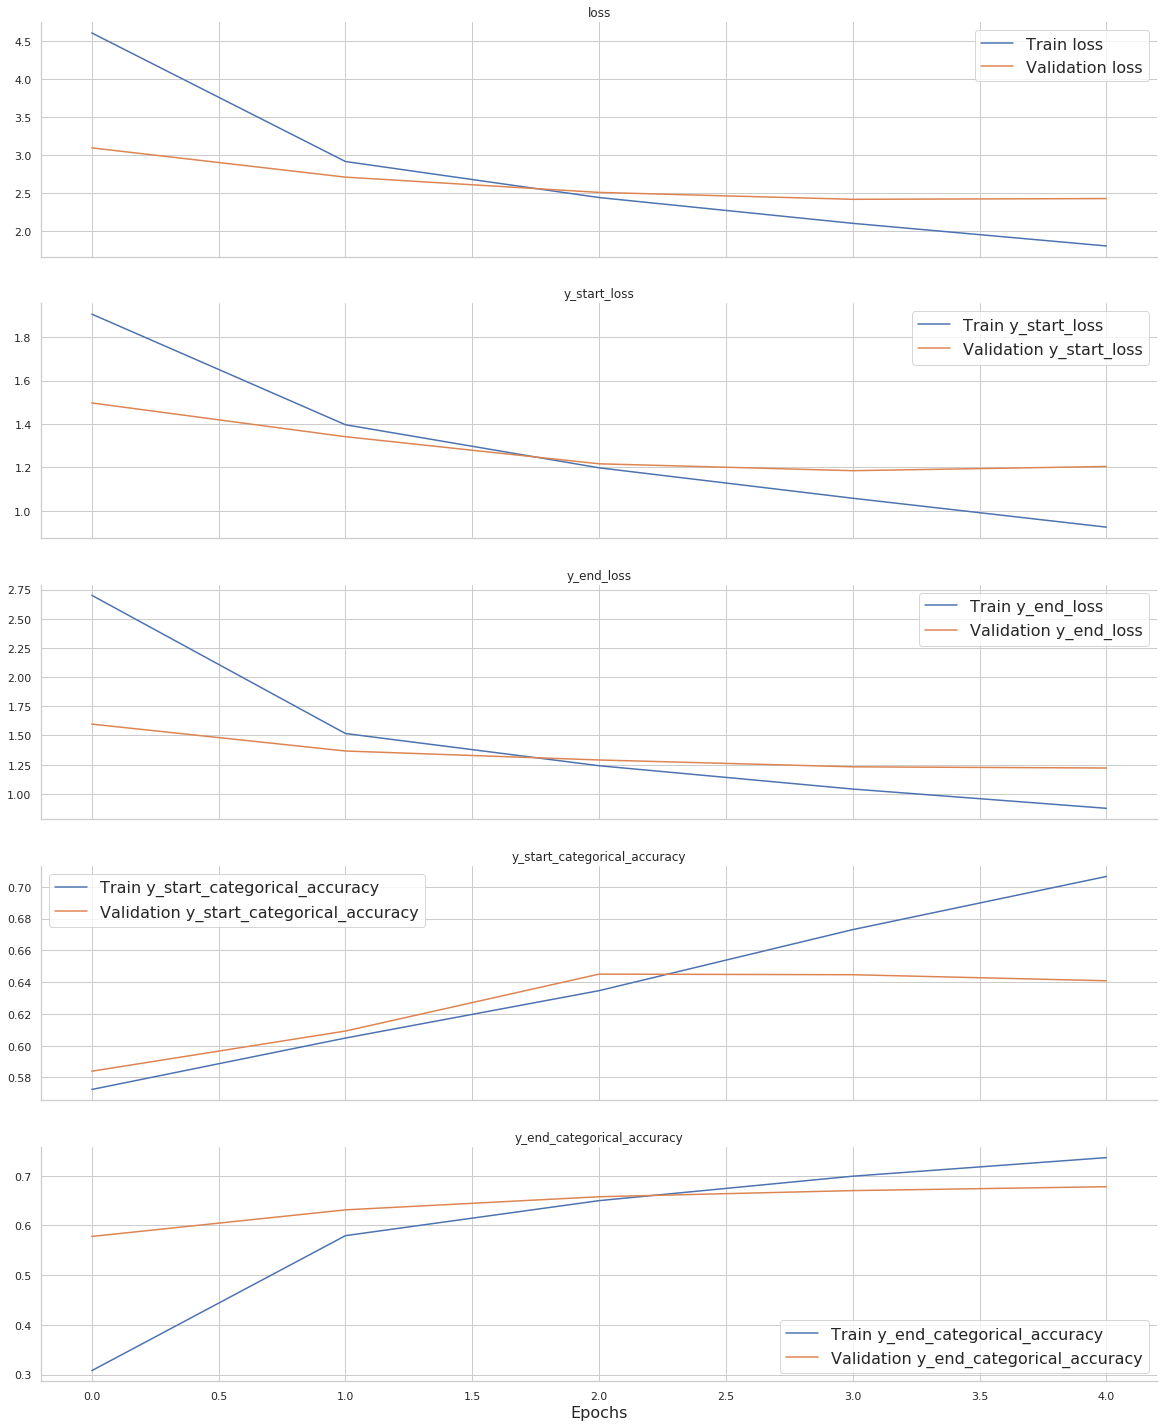

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 
                                       'y_start_categorical_accuracy', 'y_end_categorical_accuracy'])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.752511,0.660257,0.0922547,0.745026,0.657066,0.757688,0.65599,0.75482,0.667714
Sentiment neutral,0.974444,0.971267,0.0031768,0.97497,0.971341,0.973586,0.970554,0.974774,0.971906
Sentiment negative,0.606506,0.443326,0.16318,0.592103,0.441057,0.613699,0.443007,0.613716,0.445915
Sentiment positive,0.597417,0.453982,0.143435,0.585844,0.445624,0.608599,0.441429,0.597808,0.474893
0 <= text < 10,0.852364,0.81222,0.0401444,0.853414,0.769504,0.852984,0.830846,0.850694,0.83631
10 <= text < 50,0.820755,0.750959,0.069796,0.818646,0.740139,0.821028,0.755375,0.822591,0.757363
50 <= text < 100,0.730551,0.632481,0.0980708,0.723224,0.624717,0.73331,0.619276,0.73512,0.653449
100 <= text < 200,0.679969,0.562672,0.117298,0.664549,0.575581,0.696535,0.562907,0.678824,0.549527
0 <= selected text < 10,0.647055,0.479397,0.167658,0.645895,0.47818,0.652348,0.474252,0.642922,0.48576


# Visualize predictions

In [10]:
display(k_fold.head(15))

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,...,prediction_fold_1,jaccard_fold_1,start_fold_2,end_fold_2,prediction_fold_2,jaccard_fold_2,start_fold_3,end_fold_3,prediction_fold_3,jaccard_fold_3
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,...,"i`d have responded, if i were going",1.000000,4,13,"i`d have responded, if i were going",1.000000,4,13,"i`d have responded, if i were going",1.000000
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,...,sooo sad i will miss,0.500000,4,16,sooo sad i will miss you here in san diego!!!,1.000000,4,6,sooo sad,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,...,bullying me...,0.400000,7,9,bullying me...,0.400000,7,9,bullying me...,0.400000
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,...,what interview! leave me alone,1.000000,9,9,alone,0.200000,4,9,what interview! leave me alone,1.000000
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,...,"****,",0.071429,4,7,"sons of ****,",0.214286,4,7,"sons of ****,",0.214286
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,92,92,12,12,train,train,...,http://www.dothebouncy.com/smf - some shameles...,1.000000,4,30,http://www.dothebouncy.com/smf - some shameles...,1.000000,4,30,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,64,3,14,1,train,train,...,fun,0.071429,12,12,fun,0.071429,12,12,fun,0.071429
7,50e14c0bb8,soooo high,soooo high,neutral,10,10,2,2,train,train,...,soooo high,1.000000,4,6,soooo high,1.000000,4,6,soooo high,1.000000
8,e050245fbd,both of you,both of you,neutral,11,11,3,3,train,validation,...,both of you,1.000000,4,6,both of you,1.000000,4,6,both of you,1.000000
9,fc2cbefa9d,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,68,28,11,5,train,validation,...,wow...,0.100000,4,12,journey!? wow... u just became cooler.,0.600000,6,7,wow...,0.100000
